In [70]:
"""
A collection of heartrate variability algorithms for
both the timedomain and frequency domain.
Copyright (C) 2019 Luis Howell & Bernd Porr
GPL GNU GENERAL PUBLIC LICENSE Version 3, 29 June 2007
"""


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import subprocess
from scipy.interpolate import interp1d
from gatspy.periodic import LombScargleFast

class HRV:
    """
    Heartrate variability class which calcualtes the standard HRV
    parameters with the help of Python functions and for cross
    validation also via the physionet's get_hrv script.
    """

    def __init__(self, sampling_frequency):
        """
        Constructor takes the sampling frequency.
        All rr_sample data is in sample number and
        will assume it's at this sampling rate.
        """

        self.fs = float(sampling_frequency)
        self.period = 1.0/sampling_frequency

    
    def _intervals(self, rr_samples):
        """Calculate the RR intervals in ms from sample numbers.
        
        :param rr_samples: R peak sample locations
        :type rr_samples: array_like
        :return: RR intervals in milliseconds
        :rtype: ndarray
        """

        rr_intervals = np.diff(np.array(rr_samples)*self.period*1000)

        return rr_intervals

    
    def _timestamps(self, rr_samples):
        """Calculate the timestamps in ms from sample locations.
        
        :param rr_samples: R peak sample locations
        :type rr_samples: array_like
        :return: The timestamps in milliseconds
        :rtype: array_like
        """

        ts = np.array(rr_samples)*self.period*1000

        return ts

    
    def _succ_diffs(self, rr_samples):
        """Calculate the successive differences of R peaks.
        
        :param rr_samples: R peak sample locations
        :type rr_samples: array_like
        :return: The successive differences of R peaks
        :rtype: ndarray
        """

        rr_ints = self._intervals(rr_samples)

        succ_diffs = []

        for i in range(len(rr_ints)-1):

            diff = rr_ints[i+1] - rr_ints[i]            
            succ_diffs.append(diff)

        return np.array(succ_diffs)

   
    def SDNN(self, rr_samples, normalise=False):
        """Calculate SDNN, the standard deviation of NN intervals.
        
        :param rr_samples: R peak sample locations
        :type rr_samples: array_like
        :param normalise: normalise the SDNN against the average RR interval, defaults to False
        :type normalise: bool, optional
        :return: SDNN, the standard deviation of NN intervals
        :rtype: float
        """

        rr_intervals = self._intervals(rr_samples) 
        rr_std = np.std(rr_intervals)

        if normalise:
            rr_mean_interval = np.mean(rr_intervals)
            rr_std = rr_std/rr_mean_interval

        return rr_std

    
    def SDANN(self, rr_samples, average_period=5.0, normalise=False):
        """Calculate SDANN, the standard deviation of the average RR intervals calculated over short periods.
        
        :param rr_samples: R peak sample locations
        :type rr_samples: array_like
        :param average_period: The averging period in minutes, defaults to 5.0
        :type average_period: float, optional
        :param normalise: normalise the SDANN against the average RR interval, defaults to False
        :type normalise: bool, optional
        :return: SDANN, the standard deviation of the average RR intervals calculated over short periods
        :rtype: float
        """

        average_period_samples = int(self.fs*average_period*60)
        average_rr_intervals = []

        sections = int((np.max(rr_samples)/average_period_samples)+0.5)

        if sections<1:
                sections = 1

        for i in range(sections):

                idx = np.where((rr_samples>=(i*average_period_samples)) &
                               (rr_samples<((i+1)*average_period_samples)))
                idx = idx[0]
                section_rr = rr_samples[idx[0]:idx[-1]+1]

                avg_rr_int = np.mean(self._intervals(section_rr))
                average_rr_intervals.append(avg_rr_int)

        rr_std = np.std(average_rr_intervals)

        if normalise:
                rr_mean_interval = np.mean(average_rr_intervals)
                rr_std = rr_std/rr_mean_interval

        return rr_std


    def RMSSD(self, rr_samples, normalise = False):
        """Calculate RMSSD (root mean square of successive differences).
        
        :param rr_samples: R peak sample locations
        :type rr_samples: array_like
        :param normalise: normalise the RMSSD against the average RR interval, defaults to False
        :type normalise: bool, optional
        :return: RMSSD (root mean square of successive differences)
        :rtype: float
        """

        succ_diffs = self._succ_diffs(rr_samples)
        succ_diffs = succ_diffs*succ_diffs

        rms = np.sqrt(np.mean(succ_diffs))

        if normalise:
            rms = rms / np.mean(self._intervals(rr_samples))

        return rms


    def SDSD(self, rr_samples):
        """Calculate SDSD (standard deviation of successive differences), the standard deviation of the successive differences between adjacent NNs.
        
        :param rr_samples: R peak sample locations
        :type rr_samples: array_like
        :return: SDSD (standard deviation of successive differences)
        :rtype: float
        """

        succ_diffs = self._succ_diffs(rr_samples)

        return np.std(succ_diffs)        

    
    def NN50(self, rr_samples):
        """Calculate NN50, the number of pairs of successive NNs that differ by more than 50 ms.
        
        :param rr_samples: R peak sample locations
        :type rr_samples: array_like
        :return: NN50
        :rtype: float
        """

        succ_diffs = self._succ_diffs(rr_samples)

        over_50 = np.where(abs(succ_diffs)>50)
        over_50 = over_50[0]

        return len(over_50)


    def pNN50(self, rr_samples):
        """Calculate pNN50, the proportion of NN50 divided by total number of NNs.
        
        :param rr_samples: R peak sample locations
        :type rr_samples: array_like
        :return: pNN50
        :rtype: float
        """

        return self.NN50(rr_samples)/(len(rr_samples)-1)


    def NN20(self, rr_samples):
        """Calculate NN20, the number of pairs of successive NNs that differ by more than 20 ms.
        
        :param rr_samples: R peak sample locations
        :type rr_samples: array_like
        :return: NN20
        :rtype: float
        """

        succ_diffs = self._succ_diffs(rr_samples)

        over_20 = np.where(abs(succ_diffs)>20)
        over_20 = over_20[0]

        return len(over_20)


    def pNN20(self, rr_samples):
        """Calculate pNN20, the proportion of NN20 divided by total number of NNs.
        
        :param rr_samples: R peak sample locations
        :type rr_samples: array_like
        :return: pNN20
        :rtype: float
        """

        return self.NN20(rr_samples)/(len(rr_samples)-1)

    
    def HR(self, rr_samples):
        """Calculate heart-rates from R peak samples.
        
        :param rr_samples: R peak sample locations
        :type rr_samples: array_like
        :return: Heart-rates in BPM
        :rtype: ndarray
        """
        
        rr_intervals = np.diff(rr_samples)
        heart_rates = 60.0/(rr_intervals/float(self.fs))
        heart_rates = 60.0/rr_intervals
        print('avg hr', np.average(heart_rates))
        return heart_rates


    def add_rr_error(self, rr_samples, error):
        """
        Adds jitter to the heartrate timestamps. 
        The error and the rr_samples are in timestamps.
        Returns the noisy timestamps in samples.
        """
        if error==0:
            return rr_samples

        error_values = np.random.randint(-abs(error), abs(error)+1, len(rr_samples))
        noisy_rr_samples = rr_samples+error_values

        return noisy_rr_samples

    
    def fAnalysis(self, rr_samples):
        """
        Frequency analysis to calc self.lf, self.hf, returns the LF/HF-ratio and
        also calculates the spectrum as pairs of (self.f_hr_axis,self.f_hr).
        The input arrary is in sample points where R peaks have been detected.
        """
        # discrete timestamps
        self.hr_discrete = self._intervals(rr_samples) / 1000
        # hr positions in time
        self.t_hr_discrete  = [i/self.fs for i in rr_samples[1:]]
        # now let's create function which approximates the hr(t) relationship
        self.hr_func = interp1d(self.t_hr_discrete, self.hr_discrete)
        # we take 1024 samples for a linear time array for hr(t)
        nsamp = 1000
        # linear time array for the heartrate
        self.t_hr_linear = np.linspace(self.t_hr_discrete[1],
                                       self.t_hr_discrete[len(self.t_hr_discrete)-2],
                                       num=nsamp)
        # duration in secs of the heartrate array minus the ends b/c of the approx
        duration = self.t_hr_discrete[len(self.t_hr_discrete)-2] - self.t_hr_discrete[1];
        # heartrate linearly approximated between discrete samples
        self.hr_linear = self.hr_func(self.t_hr_linear)
        model = LombScargleFast().fit(self.t_hr_discrete, self.hr_discrete, 1E-2)
        fmax = 1
        fmin = 0.01
        df = (fmax - fmin) / nsamp
        self.f_hr = model.score_frequency_grid(fmin, df, nsamp)
        self.f_hr_axis = fmin + df * np.arange(nsamp)
        # lf
        self.lf = 0
        # hf
        self.hf = 0
        for i in range(0,int(nsamp/2)):
            if (self.f_hr_axis[i] >= 0.04) and (self.f_hr_axis[i] <= 0.15):
                self.lf = self.lf + self.f_hr[i]
            if (self.f_hr_axis[i] >= 0.15) and (self.f_hr_axis[i] <= 0.4):
                self.hf = self.hf + self.f_hr[i]
        # hf

Number of peaks: 11


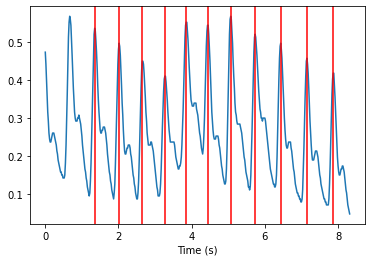

In [71]:
df = pd.read_csv('/media/brandon/Seagate HDD/datasets/vicarPPG/GroundTruth/PPG/Cleaned/01-base PPG.csv')
N = df['Signal'].values.shape[0]
stop = N - 1
stop = 500
signal = df['Signal'][:stop].values
time = df['Time'][:stop].values / 1000
plt.plot(time, signal)
plt.xlabel('Time (s)')
peaks = [df['Time'][idx]/1000 for idx, element in enumerate(df['Peaks']) if element == 1][:stop]
num_peaks = 0
for peak in peaks:
    if peak >= time[-1]:
        break
    num_peaks += 1
    plt.axvline(x = peak, color = 'r')
print(f'Number of peaks: {num_peaks}')

In [72]:
def find_IBIs(peaks):
#     IBIs = []
#     for i in range(len(peaks)-1):
#         IBIs.append(peaks[i+1] - peaks[i])
    return np.diff(peaks)

def find_hr(peaks):
    IBIs = find_IBIs(peaks)
    IBI_mean = np.average(IBIs)
    hr = 1/IBI_mean * 60 *1000
    return hr

def find_hrv(peaks):
    IBIs = find_IBIs(peaks)
    hrv = find_rmssd(IBIs) 
    sdnn = find_sdnn(IBIs) 
    return hrv, sdnn

def find_rmssd(IBIs):
    N = len(IBIs)
    ssd = 0 
    for i in range(N-1):
        ssd += (IBIs[i+1] - IBIs[i])**2
    rmssd = np.sqrt(ssd/(N-1))
    return rmssd

def find_sdnn(IBIs):
    sdnn = np.std(IBIs) 
    return sdnn

def filter_IBIs(IBIs):
    # remove IBIs outside of 250 ms and 2000 ms
    IBIs = [IBI for IBI in IBIs if IBI > 250 and IBI < 2000]
    # remove IBIs further than 3 standard deviations from the mean
    IBI_mean = np.mean(IBIs)
    IBI_std = np.std(IBIs)
    upper_limit = IBI_mean + 3*IBI_std
    lower_limit = IBI_mean - 3 * IBI_std
    print(IBI_mean, IBI_std, upper_limit, lower_limit)
    IBIs = [IBI for IBI in IBIs if IBI < upper_limit and IBI > lower_limit]
    return IBIs

avg hr 0.08915856244171713


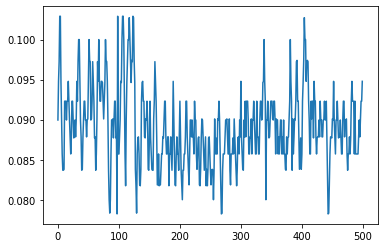

In [73]:
# peaks in ms
peaks = [df['Time'][idx] for idx, element in enumerate(df['Peaks']) if element == 1]
hrv = HRV(sampling_frequency=30)
plt.plot(hrv.HR(peaks))

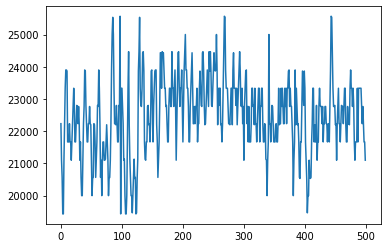

In [74]:
# print(np.diff(peaks))
plt.plot(hrv._intervals(peaks))

In [75]:
np.diff(np.array(peaks)*1.0/30*1000)
rr_intervals = np.diff(peaks)
rr_mean = np.average(rr_intervals)
heart_rates = 60.0/(rr_intervals/float(30))*1000
heart_rates
hr = 60.0/(rr_mean/float(30))*1000
hr

2667.1961544958554

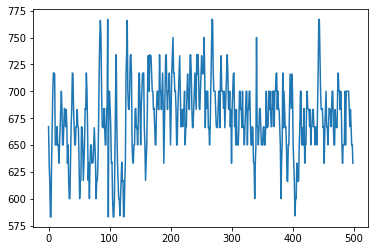

In [76]:
plt.plot(find_IBIs(peaks))

avg hr 0.08915856244171713


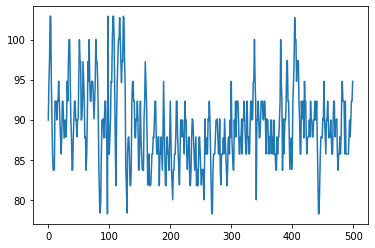

In [77]:
plt.plot(hrv.HR(peaks)*1000)

In [ ]:
signal.periodogram(find_IBIs(peaks), )

In [80]:
import scipy.signal as signal

129 129


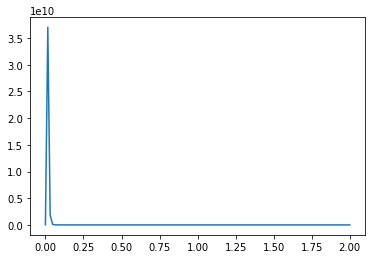

In [83]:
IBIs = peaks
f, Pxx_den = signal.welch(IBIs, fs=4)
print(len(f), len(Pxx_den))
plt.plot(f[:1,Pxx_den)